## Libraries

In [ ]:
# !pip install ctgan
# !pip install table_evaluator

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import scipy

import matplotlib.pyplot  as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from datetime import datetime

import scipy.io

# for one-hot encoder
from sklearn.preprocessing import OneHotEncoder

# for feature extraction
from sklearn.decomposition import PCA

#MinMaxScaler
from sklearn import preprocessing

# anomalous model
from sklearn.ensemble import IsolationForest

# !pip install ctgan
# for synthetic data generation
from ctgan import CTGAN

# !pip install table_evaluator
# for evaluation
from table_evaluator import TableEvaluator

# Visualising multidimensional data in 2D plane
# reeducing dimension, it has similar effect as PCA
from sklearn.manifold import TSNE

# confusion matrix
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Import Data

In [ ]:
csv_file = '2022-10-25 cdn_customer_qoe_anon.xlsx'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/DS_lab2/dataset/'+csv_file, 'cdn_customer_qoe_anon')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_excel('dataset/'+csv_file, 'cdn_customer_qoe_anon')

In [ ]:
df_buffer = df.copy() 

In [ ]:
df = df_buffer

In [ ]:
df

,Column1,Start Time,Playtime,Effective Playtime,Interruptions,Join Time,Buffer Ratio,CDN Node Host,Connection Type,Device,...,End of Playback Status,User_ID_N,Title_N,Program_N,Device_Vendor_N,Device_Model_N,Content_TV_Show_N,Country_N,City_N,Region_N
0,0,2022-07-12 00:00:14,11,10,0,0.88,0.00,NaN,Ethernet-100,Android TV,...,On Stop,564,784,0,16,64,2672,3,263,0
1,1,2022-07-12 00:00:38,73,72,0,1.17,0.00,NaN,WiFi-5,Android TV,...,On Stop,480,1,0,13,63,2672,3,76,0
2,2,2022-07-12 00:02:02,21,20,0,1.13,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,786,0,13,63,2672,3,76,0
3,3,2022-07-12 00:02:24,1,0,0,0.00,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,997,0,13,63,2672,3,76,0
4,4,2022-07-12 00:02:25,1,0,0,0.00,0.00,NaN,WiFi-5,Android TV,...,On Stop,346,997,0,13,63,2672,3,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,102251,2022-07-25 23:06:05,15282,0,0,0.00,0.00,NaN,Mobile,iPhone,...,On Stop,570,1504,0,2,153,2434,3,367,0
102252,102252,2022-07-25 22:55:39,16582,16581,0,0.99,0.00,11377663,WiFi-5,Android TV,...,On Stop,475,1014,0,13,63,2672,3,39,0
102253,102253,2022-07-25 23:09:33,21166,0,0,0.00,0.00,NaN,WiFi-5,Android,...,On Stop,249,1076,0,16,41,2672,3,56,0
102254,102254,2022-07-25 11:47:37,65122,65115,2,6.10,0.00,NaN,None,PC( Windows ),...,On Stop,622,1437,0,8,158,694,3,56,0


In [ ]:
# bringing the Numerical valued attributes names
# ====================================================
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns

## 19 columns

Index(['Column1', 'Playtime', 'Effective Playtime', 'Interruptions',
       'Join Time', 'Buffer Ratio', 'Happiness Score', 'Playback Stalls',
       'Startup Error (Count)', 'Latency', 'User_ID_N', 'Title_N', 'Program_N',
       'Device_Vendor_N', 'Device_Model_N', 'Content_TV_Show_N', 'Country_N',
       'City_N', 'Region_N'],
      dtype='object')

In [ ]:
# bringing the Categorical object valued attributes names
# ====================================================
df.select_dtypes(include=['object']).columns

## 12 columns

Index(['CDN Node Host', 'Connection Type', 'Device', 'Device Type', 'Browser',
       'Browser Version', 'OS', 'OS Version', 'Device ID', 'Happiness Value',
       'Crash Status', 'End of Playback Status'],
      dtype='object')

In [ ]:
# Date attributes names
# ====================================================

# ['Start Time, 'End Time']

## 2 columns

## Explore Data

### plot correlation matrix

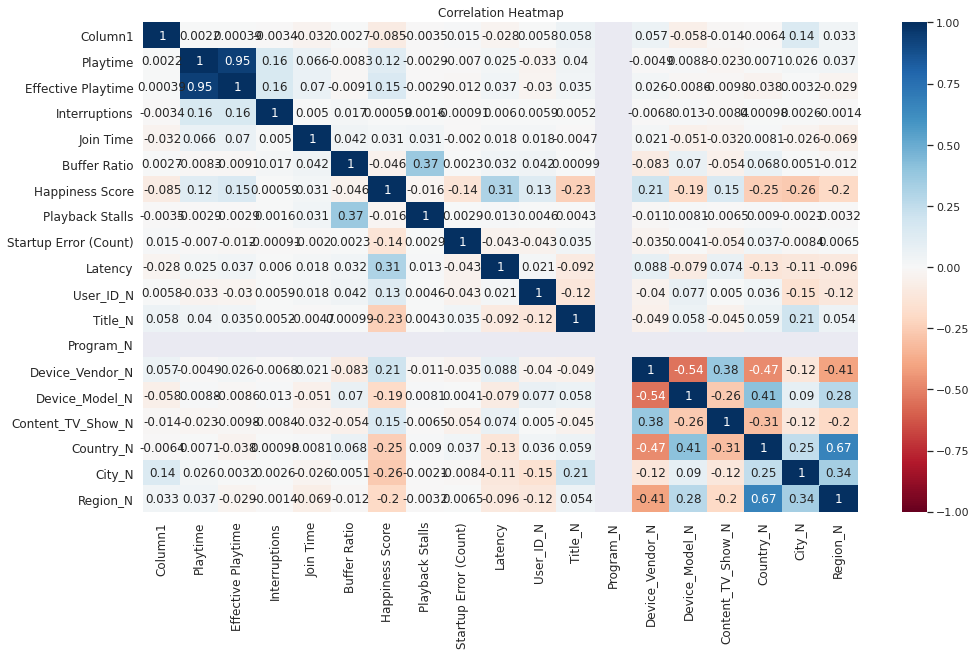

In [ ]:
plt.figure(figsize = (16, 9))
s = sns.heatmap(df.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df[['Start Time', 'End Time']]

# the time series is observed over the period of 2 weeks
# the difference between start time and end time almost fixed: 2 months and 22 days

,Start Time,End Time
0,2022-07-12 00:00:14,2022-10-04 00:00:26
1,2022-07-12 00:00:38,2022-10-04 00:01:52
2,2022-07-12 00:02:02,2022-10-04 00:02:24
3,2022-07-12 00:02:24,2022-10-04 00:02:26
4,2022-07-12 00:02:25,2022-10-04 00:02:28
...,...,...
102251,2022-07-25 23:06:05,2022-10-18 03:20:47
102252,2022-07-25 22:55:39,2022-10-18 03:32:02
102253,2022-07-25 23:09:33,2022-10-18 05:02:21
102254,2022-07-25 11:47:37,2022-10-18 05:53:00


In [ ]:
df.describe()

,Column1,Playtime,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Program_N,Device_Vendor_N,Device_Model_N,Content_TV_Show_N,Country_N,City_N,Region_N
count,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00,102256.00
mean,51127.50,328.97,288.34,0.10,1.16,0.26,5.17,0.00,0.01,13360.82,392.98,809.66,0.00,13.13,69.46,2421.41,3.93,150.77,0.03
std,29518.91,1799.36,1697.49,12.01,2.84,3.57,4.38,0.20,0.12,23550.86,161.31,527.74,0.00,4.62,33.35,631.70,2.55,107.74,0.16
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,25563.75,4.00,1.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,295.00,261.00,0.00,13.00,63.00,2672.00,3.00,76.00,0.00
50%,51127.50,22.00,17.00,0.00,0.79,0.00,6.65,0.00,0.00,17862.00,383.00,997.00,0.00,15.00,64.00,2672.00,3.00,76.00,0.00
75%,76691.25,90.00,75.00,0.00,1.30,0.00,9.61,0.00,0.00,19235.00,487.00,1170.25,0.00,16.00,64.00,2672.00,3.00,240.00,0.00
max,102255.00,86404.00,86402.00,3786.00,120.00,100.00,10.00,44.41,1.00,359477.00,699.00,1638.00,0.00,24.00,163.00,2746.00,14.00,405.00,1.00


In [ ]:
df['Buffer Ratio'].value_counts()

0.00      99621
100.00       17
0.01         11
0.01          9
0.01          8
          ...  
18.23         1
0.94          1
15.89         1
9.42          1
0.26          1
Name: Buffer Ratio, Length: 2076, dtype: int64

In [ ]:
BR_EP = df[['Buffer Ratio', 'Effective Playtime']].copy()

In [ ]:
df_buffer_ratio = BR_EP.groupby(['Buffer Ratio']).mean()

In [ ]:
df_buffer_ratio = df_buffer_ratio.sort_values(by=['Buffer Ratio'], ascending=True)

In [ ]:
df_buffer_ratio = df_buffer_ratio.reset_index()

In [ ]:
df_buffer_ratio

,Buffer Ratio,Effective Playtime
0,0.00,257.49
1,0.00,25369.80
2,0.00,8790.60
3,0.00,11359.33
4,0.00,11358.43
...,...,...
2071,98.69,1.00
2072,98.84,3.00
2073,98.94,1.00
2074,99.00,2.00


In [ ]:
print((df_buffer_ratio.columns))

Index(['Buffer Ratio', 'Effective Playtime'], dtype='object')


### QoE metrice effect on playtime

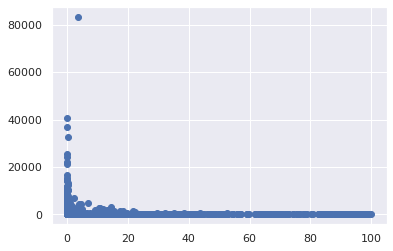

In [ ]:
plt.plot( df_buffer_ratio["Buffer Ratio"],df_buffer_ratio["Effective Playtime"], 'bo')

In [ ]:
# for better view
df_buffer_ratio_graph = df_buffer_ratio.loc[(df_buffer_ratio['Buffer Ratio'] < 40)]
df_buffer_ratio_graph = df_buffer_ratio.loc[(df_buffer_ratio['Effective Playtime'] < 8000)]

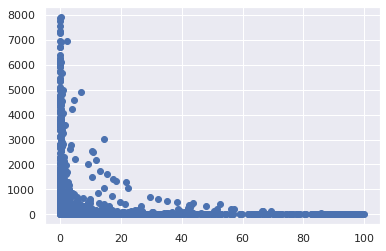

In [ ]:
plt.plot( df_buffer_ratio_graph["Buffer Ratio"],df_buffer_ratio_graph["Effective Playtime"], 'bo')

it shows the effect of buffer ratio on the effective playing time

In [ ]:
# null values
null_values = df.isnull().sum()
df_nulls = pd.DataFrame({'Column':null_values.index, 'Nulls':null_values.values})

# Count non empty cells
df_count = df_nulls
df_count = df_count.rename(columns={"Nulls": "Count"})
nb_rows = df.shape[0] # 102256
df_count.iloc[:,1] = nb_rows - df_count.iloc[:,1]

# count unique cells
uniqueValues = df.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})


In [ ]:
# merge all together in one dataframe
analyzed_df = pd.concat([df_nulls.iloc[:,0], df_count.iloc[:,1], df_nulls.iloc[:,1], df_unique.iloc[:,1]], axis = 1)
print(analyzed_df)

                    Column   Count   Nulls  Unique
0                  Column1  102256       0  102256
1               Start Time  102256       0   96503
2                 Playtime  102256       0    4752
3       Effective Playtime  102256       0    4440
4            Interruptions  102256       0      43
5                Join Time  102256       0    5554
6             Buffer Ratio  102256       0    2076
7            CDN Node Host   36979   65277     342
8          Connection Type  102256       0      19
9                   Device  102256       0      15
10             Device Type  102256       0      13
11                 Browser  102256       0      15
12         Browser Version  101411     845      64
13                      OS  102256       0       9
14              OS Version  102256       0      78
15               Device ID  102256       0    1692
16         Happiness Value  102255       1       5
17         Happiness Score  102256       0    6534
18         Playback Stalls  102

## Both are categorical: **1st** with strings, **2nd** with numbers, should do one-hot encoding except 'Happiness Score' because it is ordinal

'Connection Type', 'Device', 'Device Type', 'Browser', "Browser Version", 'OS', "OS Version", 'Crash Status', 'End of Playback Status', 'CDN Node Host'

'Device ID', 'Country_N', 'Region_N'

! 'Happiness Score' (will not)

! 'Content_TV_Show_N', will be removed due to high number of categories

In [ ]:
df['Interruptions'].value_counts()

0       99615
1        1941
2         346
3         135
4          62
5          30
6          29
7          21
8          11
10          8
13          6
12          4
9           4
11          4
20          3
21          3
16          3
15          2
17          2
24          2
55          2
18          2
143         1
25          1
23          1
44          1
179         1
66          1
83          1
125         1
37          1
85          1
45          1
43          1
103         1
26          1
58          1
489         1
14          1
3786        1
27          1
30          1
188         1
Name: Interruptions, dtype: int64

In [ ]:
# bringing the Numerical valued attributes names
# ====================================================
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).columns

## 19 columns

Index(['Column1', 'Playtime', 'Effective Playtime', 'Interruptions',
       'Join Time', 'Buffer Ratio', 'Happiness Score', 'Playback Stalls',
       'Startup Error (Count)', 'Latency', 'User_ID_N', 'Title_N', 'Program_N',
       'Device_Vendor_N', 'Device_Model_N', 'Content_TV_Show_N', 'Country_N',
       'City_N', 'Region_N'],
      dtype='object')

In [ ]:
# bringing the Categorical object valued attributes names
# ====================================================
df.select_dtypes(include=['object']).columns

## 12 columns

Index(['CDN Node Host', 'Connection Type', 'Device', 'Device Type', 'Browser',
       'Browser Version', 'OS', 'OS Version', 'Device ID', 'Happiness Value',
       'Crash Status', 'End of Playback Status'],
      dtype='object')

## Data Cleaning

remove 'Column1'

In [ ]:
df.drop(['Column1'], axis=1, inplace=True)

remove 'Program_N', it adds no value, all Zeros

In [ ]:
df.drop(['Program_N'], axis=1, inplace=True)

remove 'Playtime' due to high correlation with 'Effective Playtime'

In [ ]:
df.drop(['Playtime'], axis=1, inplace=True)

remove 'CDN Node Host' due to high percentage of missing values

In [ ]:
# df.drop(['CDN Node Host'], axis=1, inplace=True)

remove ' Happiness Value' as  Happiness score exists

In [ ]:
df.drop(['Happiness Value'], axis=1, inplace=True)

remove 'Start Time', 'End Time'
Because this in this approuch will not use time series in ADetection 

In [ ]:
df.drop(['Start Time'], axis=1, inplace=True)
df.drop(['End Time'], axis=1, inplace=True)

Removing 'Content_TV_Show_N' due to the high cardinality

In [ ]:
df.drop(['Content_TV_Show_N'], axis=1, inplace=True)

Removing 'Device ID'

In [ ]:
df.drop(['Device ID'], axis=1, inplace=True)

keeping the 'Crash Status' as the empty values means no crash happened

In [ ]:
df['Crash Status'].value_counts()

Startup Error Crash      1276
In Stream Error Crash     569
Name: Crash Status, dtype: int64

# filling missing data

### !!! This step is skipped as missing data can be a data invention, which is usually unwanted in real-life envs.

In [ ]:
# df['Browser Version'].fillna(df['Browser Version'].mode()[0], inplace = True)

In [ ]:
# df['Crash Status'] = df['Crash Status'].fillna('no crash')

In [ ]:
# df['End of Playback Status'].fillna(df['End of Playback Status'].mode()[0], inplace = True)

Some histogram plotting 

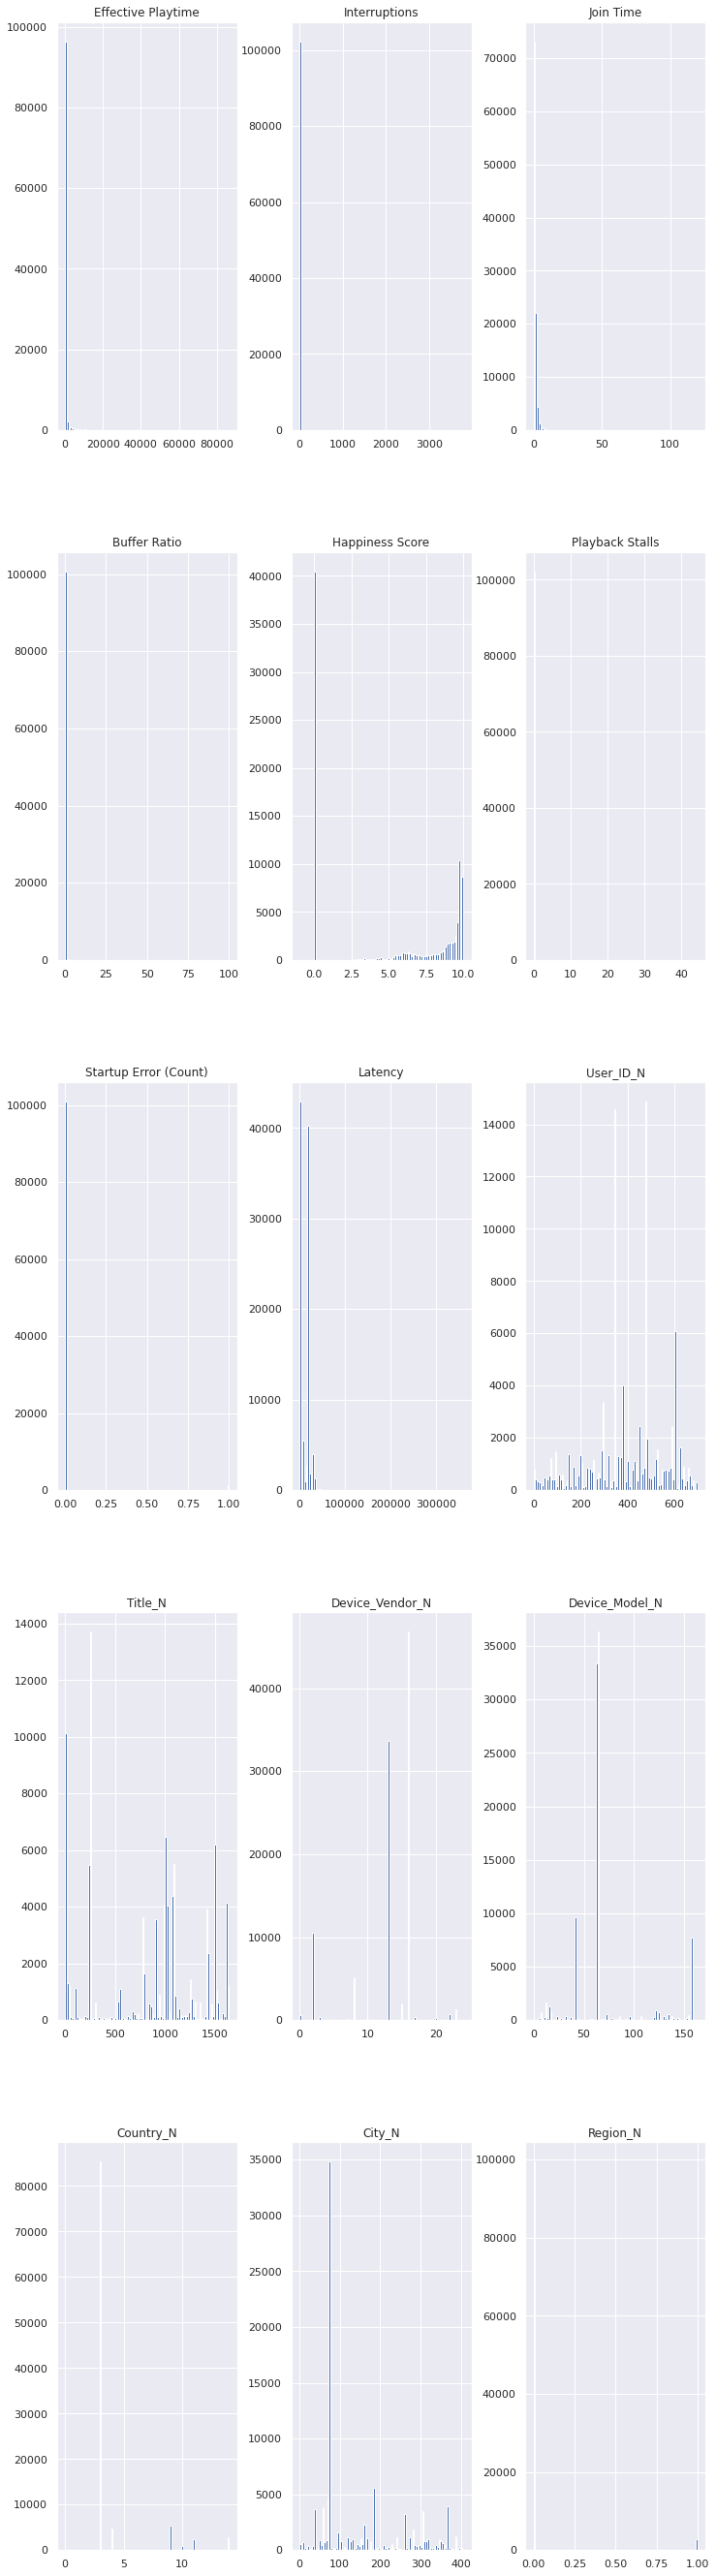

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numerical_fts = df.select_dtypes(include=numerics).columns

fig, axes = plt.subplots(len(df[df_numerical_fts].columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df[df_numerical_fts].hist(column = df[df_numerical_fts].columns[i], bins = 100, ax=axis)
        i = i+1

# Milestone

In [ ]:
# null values
null_values = df.isnull().sum()
df_nulls = pd.DataFrame({'Column':null_values.index, 'Nulls':null_values.values})

# Count non empty cells
df_count = df_nulls
df_count = df_count.rename(columns={"Nulls": "Count"})
nb_rows = df.shape[0] # 102256
df_count.iloc[:,1] = nb_rows - df_count.iloc[:,1]

# count unique cells
uniqueValues = df.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})

In [ ]:
# merge all together in one dataframe
analyzed_df = pd.concat([df_nulls.iloc[:,0], df_count.iloc[:,1], df_nulls.iloc[:,1], df_unique.iloc[:,1]], axis = 1)
print(analyzed_df)

                    Column   Count   Nulls  Unique
0       Effective Playtime  102256       0    4440
1            Interruptions  102256       0      43
2                Join Time  102256       0    5554
3             Buffer Ratio  102256       0    2076
4            CDN Node Host   36979   65277     342
5          Connection Type  102256       0      19
6                   Device  102256       0      15
7              Device Type  102256       0      13
8                  Browser  102256       0      15
9          Browser Version  101411     845      64
10                      OS  102256       0       9
11              OS Version  102256       0      78
12         Happiness Score  102256       0    6534
13         Playback Stalls  102256       0     425
14   Startup Error (Count)  102256       0       2
15                 Latency  102256       0   13416
16            Crash Status    1845  100411       2
17  End of Playback Status  102255       1       4
18               User_ID_N  102

In [ ]:
df_2 = df.copy() 

In [ ]:
# df = df_2

# Encoding with get_dummies

In [ ]:
# to be encoded
df_categorical_fields_encod = ['Connection Type', 'Device', 'Device Type', 'Browser', "Browser Version", 'OS', "OS Version", 'Crash Status', 'End of Playback Status', 'Country_N', 'Region_N', 'CDN Node Host']

In [ ]:
df.shape

(102256, 25)

In [ ]:
encoded_features =pd.get_dummies(data=df, columns= df_categorical_fields_encod)

In [ ]:
encoded_features

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,CDN Node Host_e401ecd48,CDN Node Host_e5a3a18d4,CDN Node Host_ea23f8087,CDN Node Host_ea8d72ad8,CDN Node Host_ef71f4254,CDN Node Host_efbbe67ab,CDN Node Host_f058c444b,CDN Node Host_fe41d9cfb,CDN Node Host_feaa97dbf,CDN Node Host_ff4e3e8ab
0,10,0,0.88,0.00,7.39,0.00,0,19504,564,784,...,0,0,0,0,0,0,0,0,0,0
1,72,0,1.17,0.00,9.40,0.00,0,19033,480,1,...,0,0,0,0,0,0,0,0,0,0
2,20,0,1.13,0.00,7.00,0.00,0,19071,346,786,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0,0,0.00,0.00,0.00,0.00,0,0,570,1504,...,0,0,0,0,0,0,0,0,0,0
102252,16581,0,0.99,0.00,10.00,0.00,0,18191,475,1014,...,0,0,0,0,0,0,0,0,0,0
102253,0,0,0.00,0.00,0.00,0.00,0,0,249,1076,...,0,0,0,0,0,0,0,0,0,0
102254,65115,2,6.10,0.00,7.46,0.00,0,27550,622,1437,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# drop the features that was encoeded from get_dummies
df.drop(df_categorical_fields_encod, axis=1 ,inplace=True)

In [ ]:
df=pd.concat([encoded_features,df], axis='columns')

In [ ]:
df.shape

(102256, 604)

In [ ]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,City_N
0,10,0,0.88,0.00,7.39,0.00,0,19504,564,784,...,0.00,7.39,0.00,0,19504,564,784,16,64,263
1,72,0,1.17,0.00,9.40,0.00,0,19033,480,1,...,0.00,9.40,0.00,0,19033,480,1,13,63,76
2,20,0,1.13,0.00,7.00,0.00,0,19071,346,786,...,0.00,7.00,0.00,0,19071,346,786,13,63,76
3,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0.00,0.00,0.00,0,0,346,997,13,63,76
4,0,0,0.00,0.00,0.00,0.00,0,0,346,997,...,0.00,0.00,0.00,0,0,346,997,13,63,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0,0,0.00,0.00,0.00,0.00,0,0,570,1504,...,0.00,0.00,0.00,0,0,570,1504,2,153,367
102252,16581,0,0.99,0.00,10.00,0.00,0,18191,475,1014,...,0.00,10.00,0.00,0,18191,475,1014,13,63,39
102253,0,0,0.00,0.00,0.00,0.00,0,0,249,1076,...,0.00,0.00,0.00,0,0,249,1076,16,41,56
102254,65115,2,6.10,0.00,7.46,0.00,0,27550,622,1437,...,0.00,7.46,0.00,0,27550,622,1437,8,158,56


# Milestone

In [ ]:
df_3 = df.copy() 

## setup of anomalous detection

### min-max scaler for the model

In [ ]:
# MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [ ]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,City_N
0,0.00,0.00,0.01,0.00,0.76,0.00,0.00,0.05,0.81,0.48,...,0.00,0.76,0.00,0.00,0.05,0.81,0.48,0.67,0.39,0.65
1,0.00,0.00,0.01,0.00,0.95,0.00,0.00,0.05,0.69,0.00,...,0.00,0.95,0.00,0.00,0.05,0.69,0.00,0.54,0.39,0.19
2,0.00,0.00,0.01,0.00,0.73,0.00,0.00,0.05,0.49,0.48,...,0.00,0.73,0.00,0.00,0.05,0.49,0.48,0.54,0.39,0.19
3,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.09,0.00,0.00,0.00,0.49,0.61,0.54,0.39,0.19
4,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.00,0.09,0.00,0.00,0.00,0.49,0.61,0.54,0.39,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.82,0.92,...,0.00,0.09,0.00,0.00,0.00,0.82,0.92,0.08,0.94,0.91
102252,0.19,0.00,0.01,0.00,1.00,0.00,0.00,0.05,0.68,0.62,...,0.00,1.00,0.00,0.00,0.05,0.68,0.62,0.54,0.39,0.10
102253,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.36,0.66,...,0.00,0.09,0.00,0.00,0.00,0.36,0.66,0.67,0.25,0.14
102254,0.75,0.00,0.05,0.00,0.77,0.00,0.00,0.08,0.89,0.88,...,0.00,0.77,0.00,0.00,0.08,0.89,0.88,0.33,0.97,0.14


### Generating of the Isolation Forest model and setting the parameters

In [ ]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=0.01)

### Model fitting with the dataset we have for detecting anomaly

In [ ]:
model.fit(df)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=42)

### Adding the anomaly score after applying Isolation Forest to the data we have 

In [ ]:
df['Anomaly'] = pd.Series(model.predict(df))

In [ ]:
df.shape

(102256, 605)

In [ ]:
df

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,City_N,Anomaly
0,0.00,0.00,0.01,0.00,0.76,0.00,0.00,0.05,0.81,0.48,...,0.76,0.00,0.00,0.05,0.81,0.48,0.67,0.39,0.65,1
1,0.00,0.00,0.01,0.00,0.95,0.00,0.00,0.05,0.69,0.00,...,0.95,0.00,0.00,0.05,0.69,0.00,0.54,0.39,0.19,1
2,0.00,0.00,0.01,0.00,0.73,0.00,0.00,0.05,0.49,0.48,...,0.73,0.00,0.00,0.05,0.49,0.48,0.54,0.39,0.19,1
3,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.09,0.00,0.00,0.00,0.49,0.61,0.54,0.39,0.19,1
4,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.49,0.61,...,0.09,0.00,0.00,0.00,0.49,0.61,0.54,0.39,0.19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.82,0.92,...,0.09,0.00,0.00,0.00,0.82,0.92,0.08,0.94,0.91,1
102252,0.19,0.00,0.01,0.00,1.00,0.00,0.00,0.05,0.68,0.62,...,1.00,0.00,0.00,0.05,0.68,0.62,0.54,0.39,0.10,1
102253,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.36,0.66,...,0.09,0.00,0.00,0.00,0.36,0.66,0.67,0.25,0.14,1
102254,0.75,0.00,0.05,0.00,0.77,0.00,0.00,0.08,0.89,0.88,...,0.77,0.00,0.00,0.08,0.89,0.88,0.33,0.97,0.14,-1


In [ ]:
# Labelling anomalous requests detected by Isolation Forest 
df['Anomaly'] = df['Anomaly'].map( {1: 0, -1: 1} )

In [ ]:
df['Anomaly'].value_counts()

0    101233
1      1023
Name: Anomaly, dtype: int64

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(df)
reduced_fts = np.array(tsne_results)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
reduced_fts = pd.DataFrame(reduced_fts, columns = ['ft_one','ft_two'])

In [ ]:
reduced_fts = pd.DataFrame(reduced_fts, columns = ['ft_one','ft_two'])

In [ ]:
# add the output to the reduced features
reduced_fts['Anomaly'] = df['Anomaly']

In [ ]:
reduced_fts

,ft_one,ft_two,Anomaly
0,-2.8470,-14.4195,0
1,0.5377,7.7299,0
2,0.6814,1.1628,0
3,15.5829,-7.4792,0
4,15.5827,-7.4791,0
...,...,...,...
102251,16.2048,11.2491,0
102252,4.4919,3.4044,0
102253,-7.9090,8.6243,0
102254,-3.3133,6.3363,1


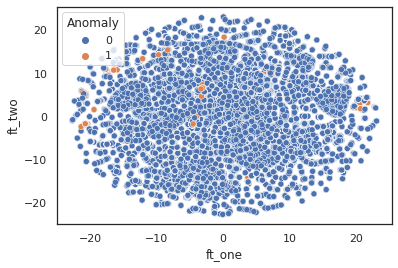

In [ ]:
# Scatterplot visualisation 
sns.scatterplot(
    x="ft_one", y="ft_two",
    hue="Anomaly",
    data= reduced_fts,
    legend="full",
    alpha=1
)

## Dispaly the properites of anomalous records


In [ ]:
df_buffer

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,City_N
0,10,0,0.88,0.00,7.39,0.00,0,19504,564,784,16,64,263
1,72,0,1.17,0.00,9.40,0.00,0,19033,480,1,13,63,76
2,20,0,1.13,0.00,7.00,0.00,0,19071,346,786,13,63,76
3,0,0,0.00,0.00,0.00,0.00,0,0,346,997,13,63,76
4,0,0,0.00,0.00,0.00,0.00,0,0,346,997,13,63,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102251,0,0,0.00,0.00,0.00,0.00,0,0,570,1504,2,153,367
102252,16581,0,0.99,0.00,10.00,0.00,0,18191,475,1014,13,63,39
102253,0,0,0.00,0.00,0.00,0.00,0,0,249,1076,16,41,56
102254,65115,2,6.10,0.00,7.46,0.00,0,27550,622,1437,8,158,56


In [ ]:
df_2_all = df_2.copy()

In [ ]:
df_2_all['Anomaly'] = df['Anomaly']
# df_2_all['Column1'] = df_buffer['Column1']

In [ ]:
df_anom = df_2_all[df_2_all['Anomaly'] == 1]

In [ ]:
df_buffer['Interruptions'].value_counts()
# df_buffer['Country_N'].value_counts()

0       99615
1        1941
2         346
3         135
4          62
5          30
6          29
7          21
8          11
10          8
13          6
12          4
9           4
11          4
20          3
21          3
16          3
15          2
17          2
24          2
55          2
18          2
143         1
25          1
23          1
44          1
179         1
66          1
83          1
125         1
37          1
85          1
45          1
43          1
103         1
26          1
58          1
489         1
14          1
3786        1
27          1
30          1
188         1
Name: Interruptions, dtype: int64

In [ ]:
df_anom['Interruptions'].value_counts()
# df_anom['Country_N'].value_counts()

1       535
0       234
2       111
3        51
4        20
5        12
6        11
7        10
8         5
13        3
20        2
10        2
18        2
16        2
9         2
55        2
24        2
23        1
179       1
83        1
143       1
15        1
188       1
21        1
103       1
66        1
25        1
85        1
26        1
125       1
489       1
3786      1
12        1
17        1
Name: Interruptions, dtype: int64

In [ ]:
df_anom.describe()

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,Country_N,City_N,Region_N,Anomaly
count,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00,1023.00
mean,1463.87,6.80,2.20,9.38,4.65,0.08,0.05,26838.03,444.55,843.67,9.73,91.80,6.39,198.85,0.00,1.00
std,5441.36,119.83,3.16,21.77,2.70,0.21,0.22,49984.32,183.42,535.55,5.16,63.61,3.58,118.65,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,0.00,6.00,1.00,0.00,0.00,1.00
25%,8.00,1.00,0.98,0.01,3.10,0.00,0.00,0.00,354.50,261.00,8.00,17.00,3.00,76.00,0.00,1.00
50%,32.00,1.00,1.53,0.74,4.50,0.01,0.00,0.00,438.00,937.00,8.00,72.00,4.00,167.00,0.00,1.00
75%,525.00,1.00,2.58,6.32,7.13,0.04,0.00,32180.00,589.00,1412.00,15.00,158.00,11.00,314.00,0.00,1.00
max,83321.00,3786.00,42.65,99.00,9.99,0.99,1.00,333214.00,699.00,1638.00,23.00,163.00,11.00,391.00,0.00,1.00


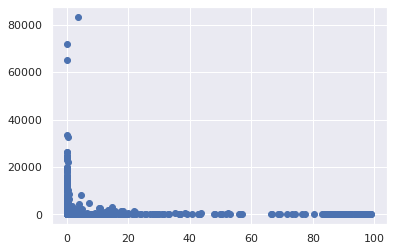

In [ ]:
plt.plot( df_anom["Buffer Ratio"],df_anom["Effective Playtime"], 'bo')

Statisitcal analysis:
--------------------
anomaly = 1023;
normal = 101233;

anomaly % = (anomaly/(anomaly + normal)) * 100 = (1023/102256) * 100 = 1.00043 ~ 1 %

#########



#########

# Synthetic data gerneration
in this task, two spereate sets of data will be generated: **anomalous** and **non-anomalous** .

Note: theb data generated is the usfeull, meaningfull data after cleaning and preprocessing that wil be usefull for the model

In [ ]:
original_set = df_2.copy()

In [ ]:
original_set['Anomaly'] = df['Anomaly']

In [ ]:
original_set_without_anom = original_set.loc[original_set['Anomaly'] == 0]
original_set_with_anom = original_set.loc[original_set['Anomaly'] == 1]

Prepare fields for the model, the discrete fields should be passed through an array.

In [ ]:
# Names of the columns that are discrete
discrete_columns =  [
    'Connection Type', 
    'Device', 
    'Device Type', 
    'Browser', 
    'Browser Version', 
    'OS', 
    'OS Version', 
    'Crash Status', 
    'End of Playback Status', 
    'Country_N', 
    'Region_N',
    'CDN Node Host'
    ]

In [ ]:
print(original_set_without_anom.columns[0:8])

Index(['Effective Playtime', 'Interruptions', 'Join Time', 'Buffer Ratio',
       'CDN Node Host', 'Connection Type', 'Device', 'Device Type'],
      dtype='object')


In [ ]:
print(original_set_without_anom.columns[8:16])

Index(['Browser', 'Browser Version', 'OS', 'OS Version', 'Happiness Score',
       'Playback Stalls', 'Startup Error (Count)', 'Latency'],
      dtype='object')


In [ ]:
original_set_without_anom

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,CDN Node Host,Connection Type,Device,Device Type,Browser,Browser Version,...,Crash Status,End of Playback Status,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,Country_N,City_N,Region_N,Anomaly
0,10,0,0.88,0.00,NaN,Ethernet-100,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,564,784,16,64,3,263,0,0
1,72,0,1.17,0.00,NaN,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,480,1,13,63,3,76,0,0
2,20,0,1.13,0.00,NaN,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,346,786,13,63,3,76,0,0
3,0,0,0.00,0.00,NaN,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,346,997,13,63,3,76,0,0
4,0,0,0.00,0.00,NaN,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,346,997,13,63,3,76,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102249,13211,1,41.12,0.26,NaN,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,In Stream Error Crash,On Error,224,1412,13,63,3,39,0,0
102251,0,0,0.00,0.00,NaN,Mobile,iPhone,SmartPhone,Mobile Safari,Mobile Safari,...,NaN,On Stop,570,1504,2,153,3,367,0,0
102252,16581,0,0.99,0.00,11377663,WiFi-5,Android TV,TV,Android Browser,Android Browser,...,NaN,On Stop,475,1014,13,63,3,39,0,0
102253,0,0,0.00,0.00,NaN,WiFi-5,Android,STBAndroid,Android Browser,Android Browser,...,NaN,On Stop,249,1076,16,41,3,56,0,0


### Building the CTGAN model and setting the epochs which is total number of iterations of all the training data in one cycle for training the machine learning model.
### After model is trained, **9900** record is generated.

In [ ]:
ctgan = CTGAN(epochs=6)
ctgan.fit(original_set_without_anom, discrete_columns)

# Create synthetic data
synthetic_data_without_anom = ctgan.sample(9900)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Saving model for later use to avoid training time.

In [ ]:
ctgan.save('CTGAN_model.pkl')

In [ ]:
# loaded = CTGAN.load('CTGAN_model.pkl')
# synthetic_data_without_anom = loaded.sample(9900)

### Building the CTGAN model and setting the epochs which is total number of iterations of all the training data in one cycle for training the machine learning model.
### After model is trained, **100** record is generated.

In [ ]:
ctgan_anom = CTGAN(epochs=15)
ctgan_anom.fit(original_set_with_anom, discrete_columns)

# Create synthetic data
synthetic_data_with_anom = ctgan_anom.sample(100)

Saving model for later use to avoid training time.

In [ ]:
ctgan_anom.save('CTGAN_model_anom.pkl')

In [ ]:
# ctgan_anom = CTGAN.load('CTGAN_model_anom.pkl')
# synthetic_data_with_anom = ctgan_anom.sample(100)

## Add data to each other

In [ ]:
synthetic_data = synthetic_data_without_anom.append(synthetic_data_with_anom, ignore_index=True)

# for testing similarity

## in the whole features (normal)

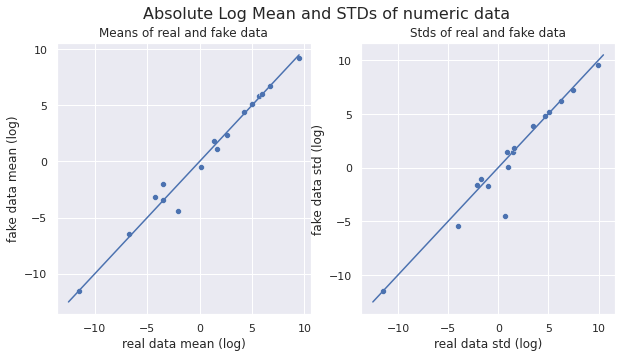

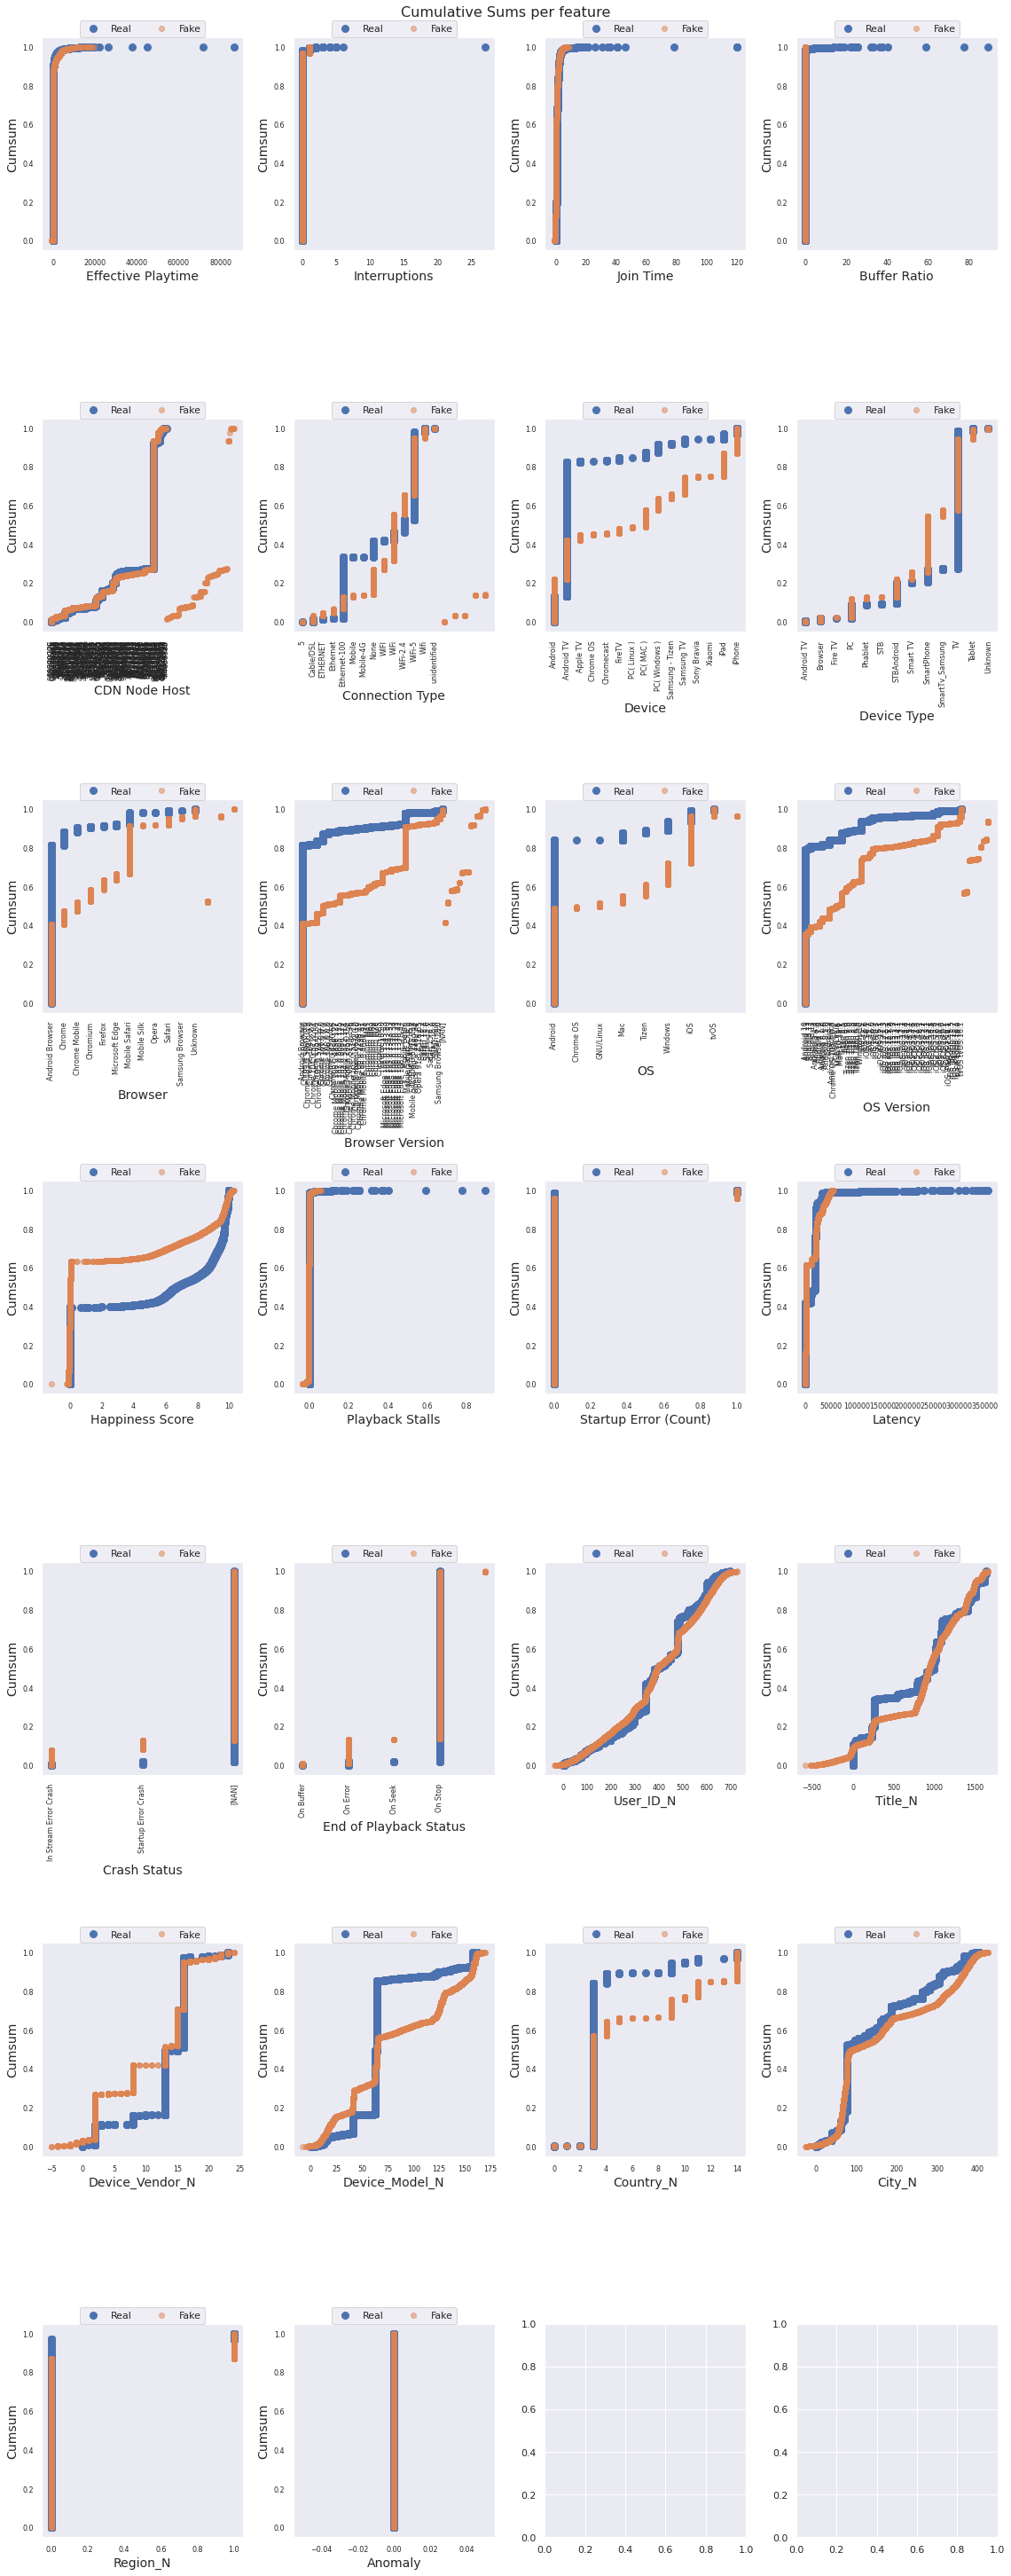

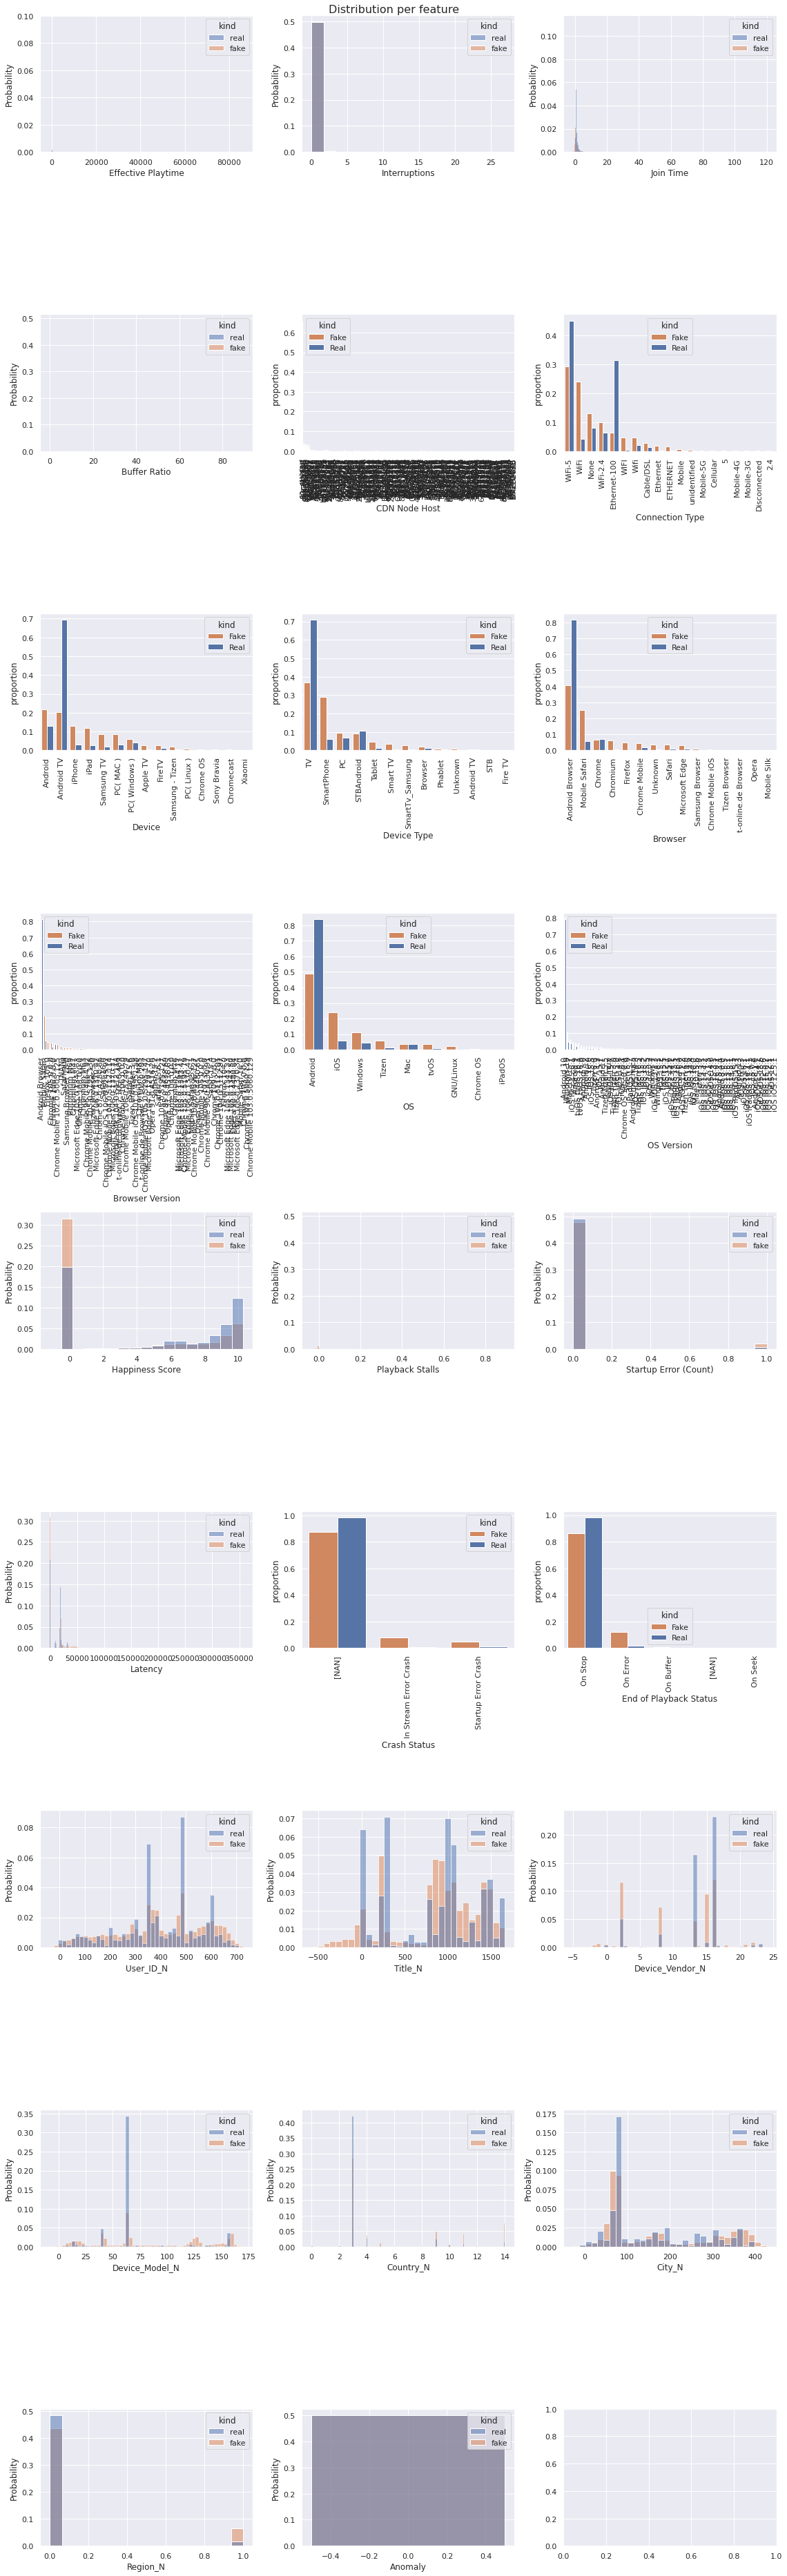

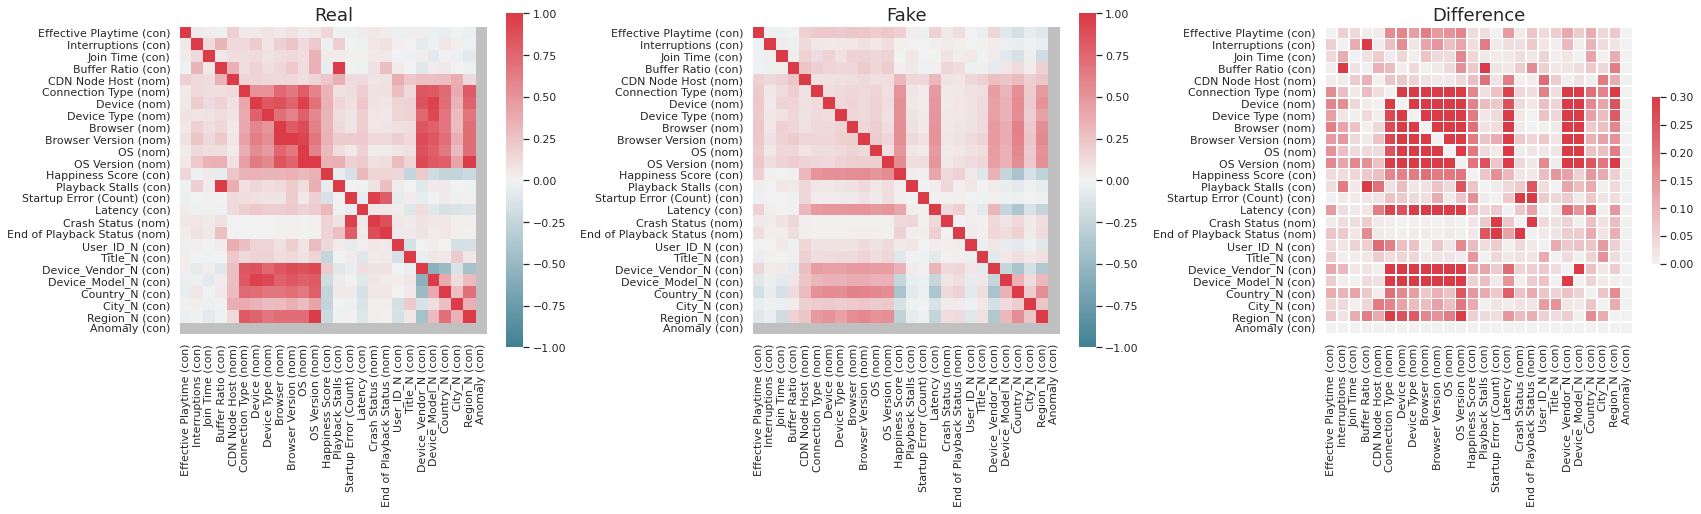

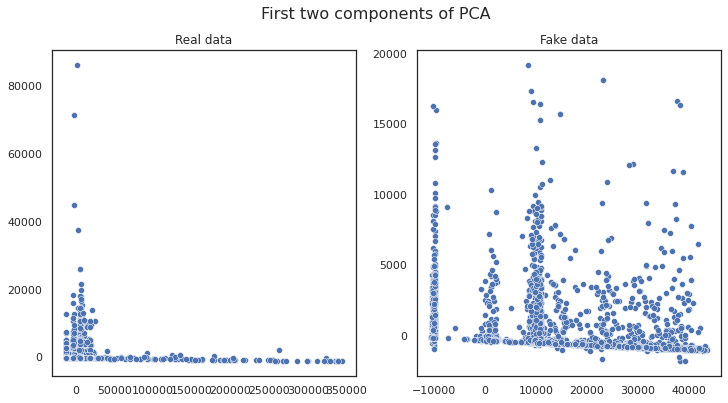

In [ ]:
table_evaluator = TableEvaluator(original_set_without_anom, synthetic_data_without_anom)
table_evaluator.visual_evaluation()

## in the specific feature (normal)

In [ ]:
table_evaluator.evaluate(target_col='Effective Playtime')

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.0136   0.0061              0.0076
DecisionTreeClassifier_real   0.3662   0.0030              0.0023
LogisticRegression_fake       0.0121   0.0197              0.0238
LogisticRegression_real       0.2439   0.0247              0.0056
MLPClassifier_fake            0.0086   0.0121              0.0015
MLPClassifier_real            0.2051   0.0086              0.0008
RandomForestClassifier_fake   0.0131   0.0096              0.0061
RandomForestClassifier_real   0.3818   0.0111              0.0053

Privacy results:
                                           result
Duplicate rows between sets (real/fake)  (483, 0)
nearest neighbor mean                      2.6278
nearest neighbor std                       1.6904

Miscellaneous results:
                                  Result
Co

## in the whole features (anomalous)

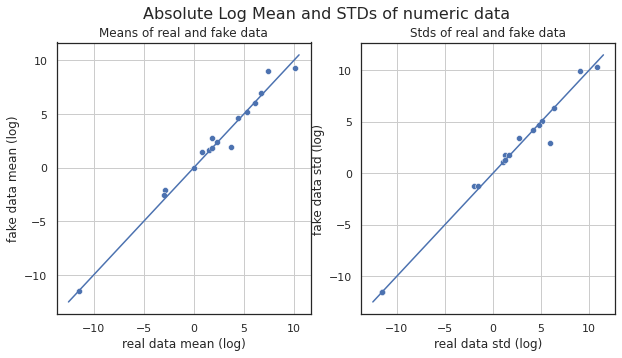

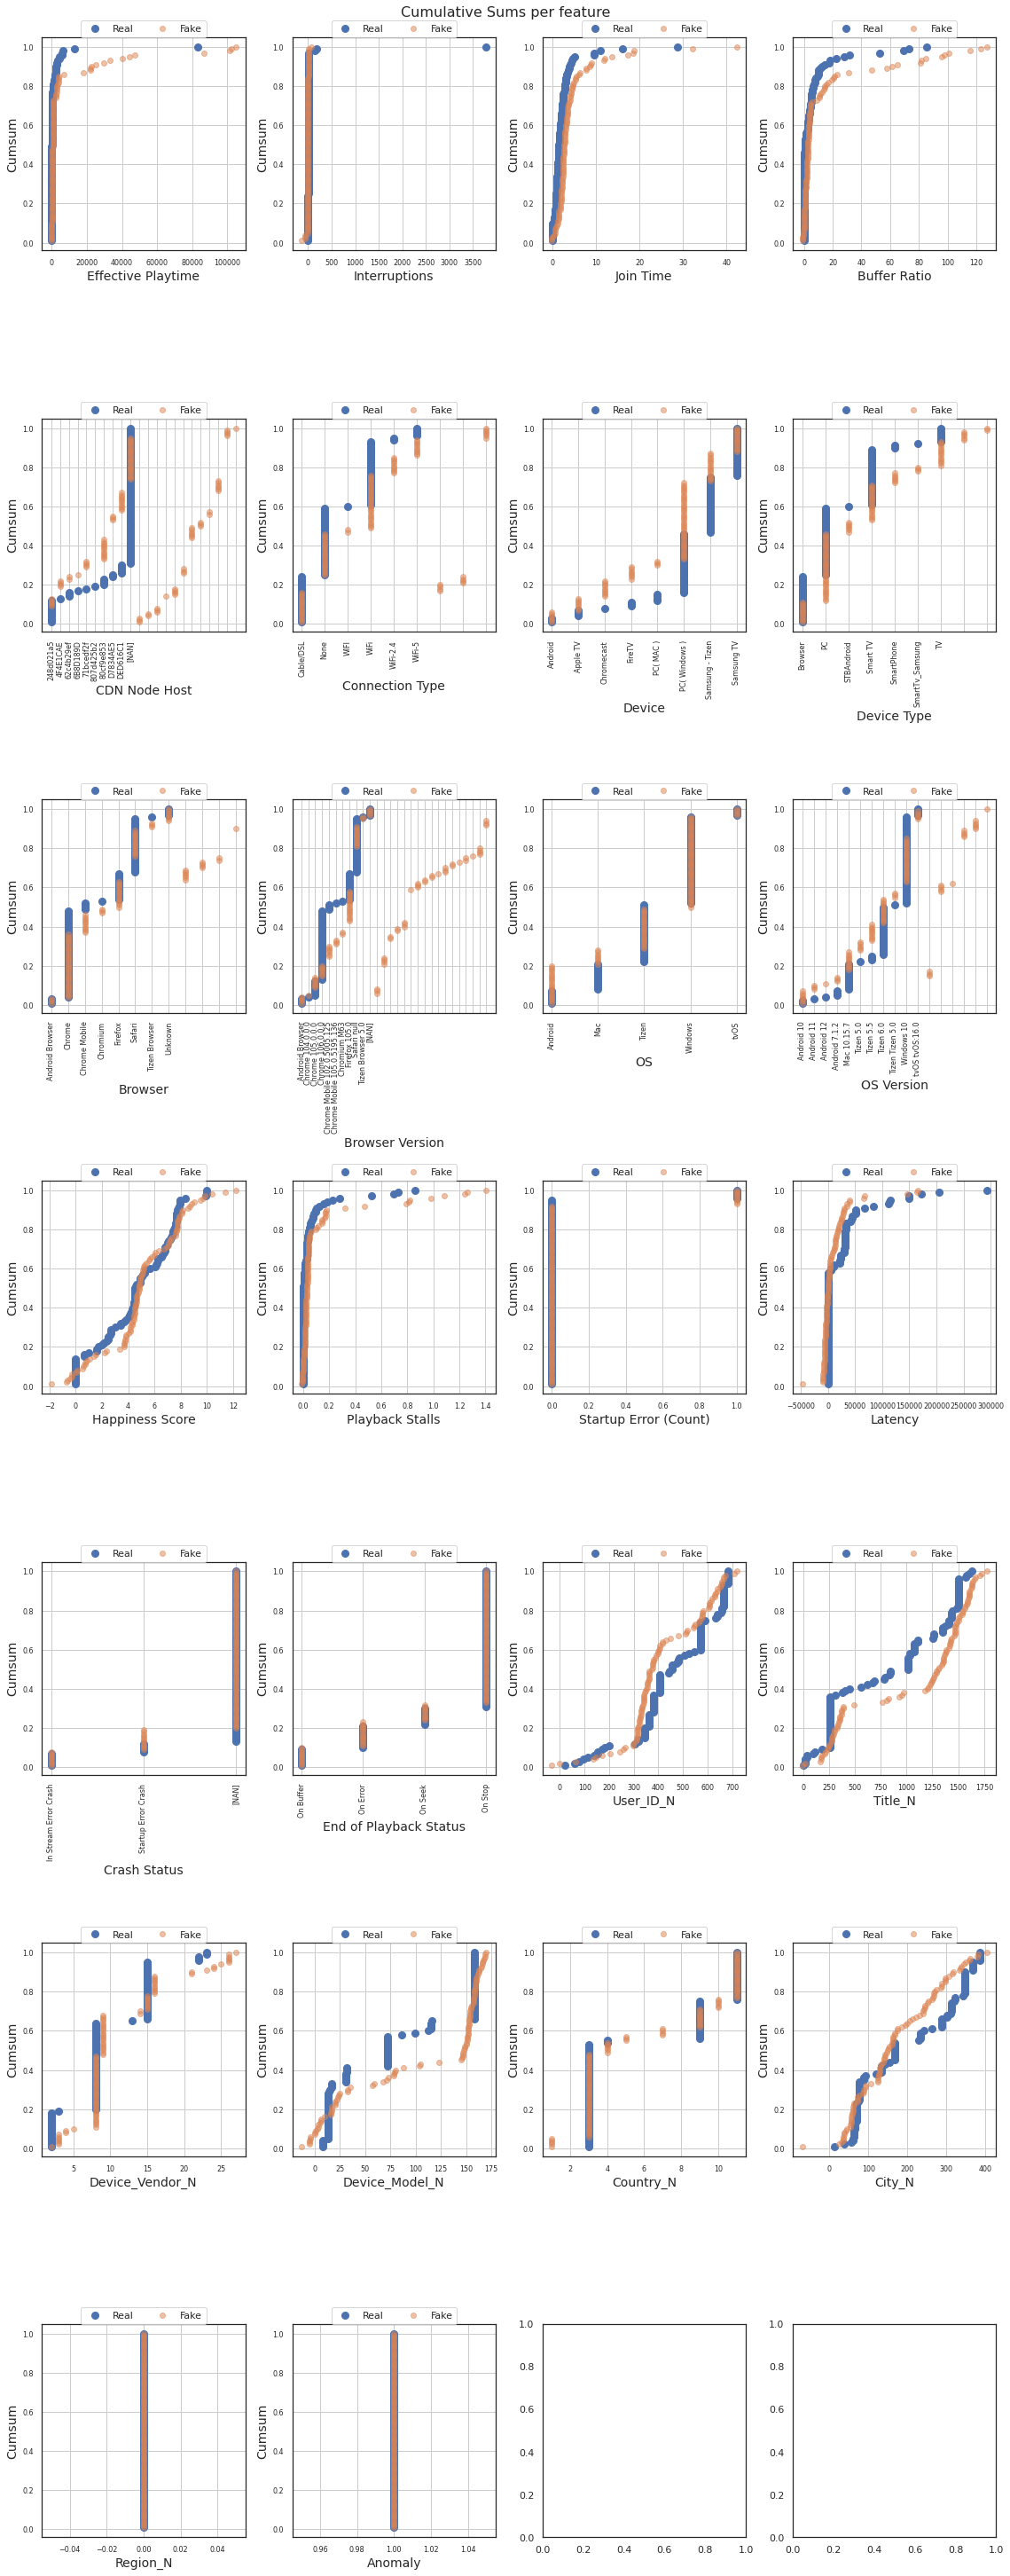

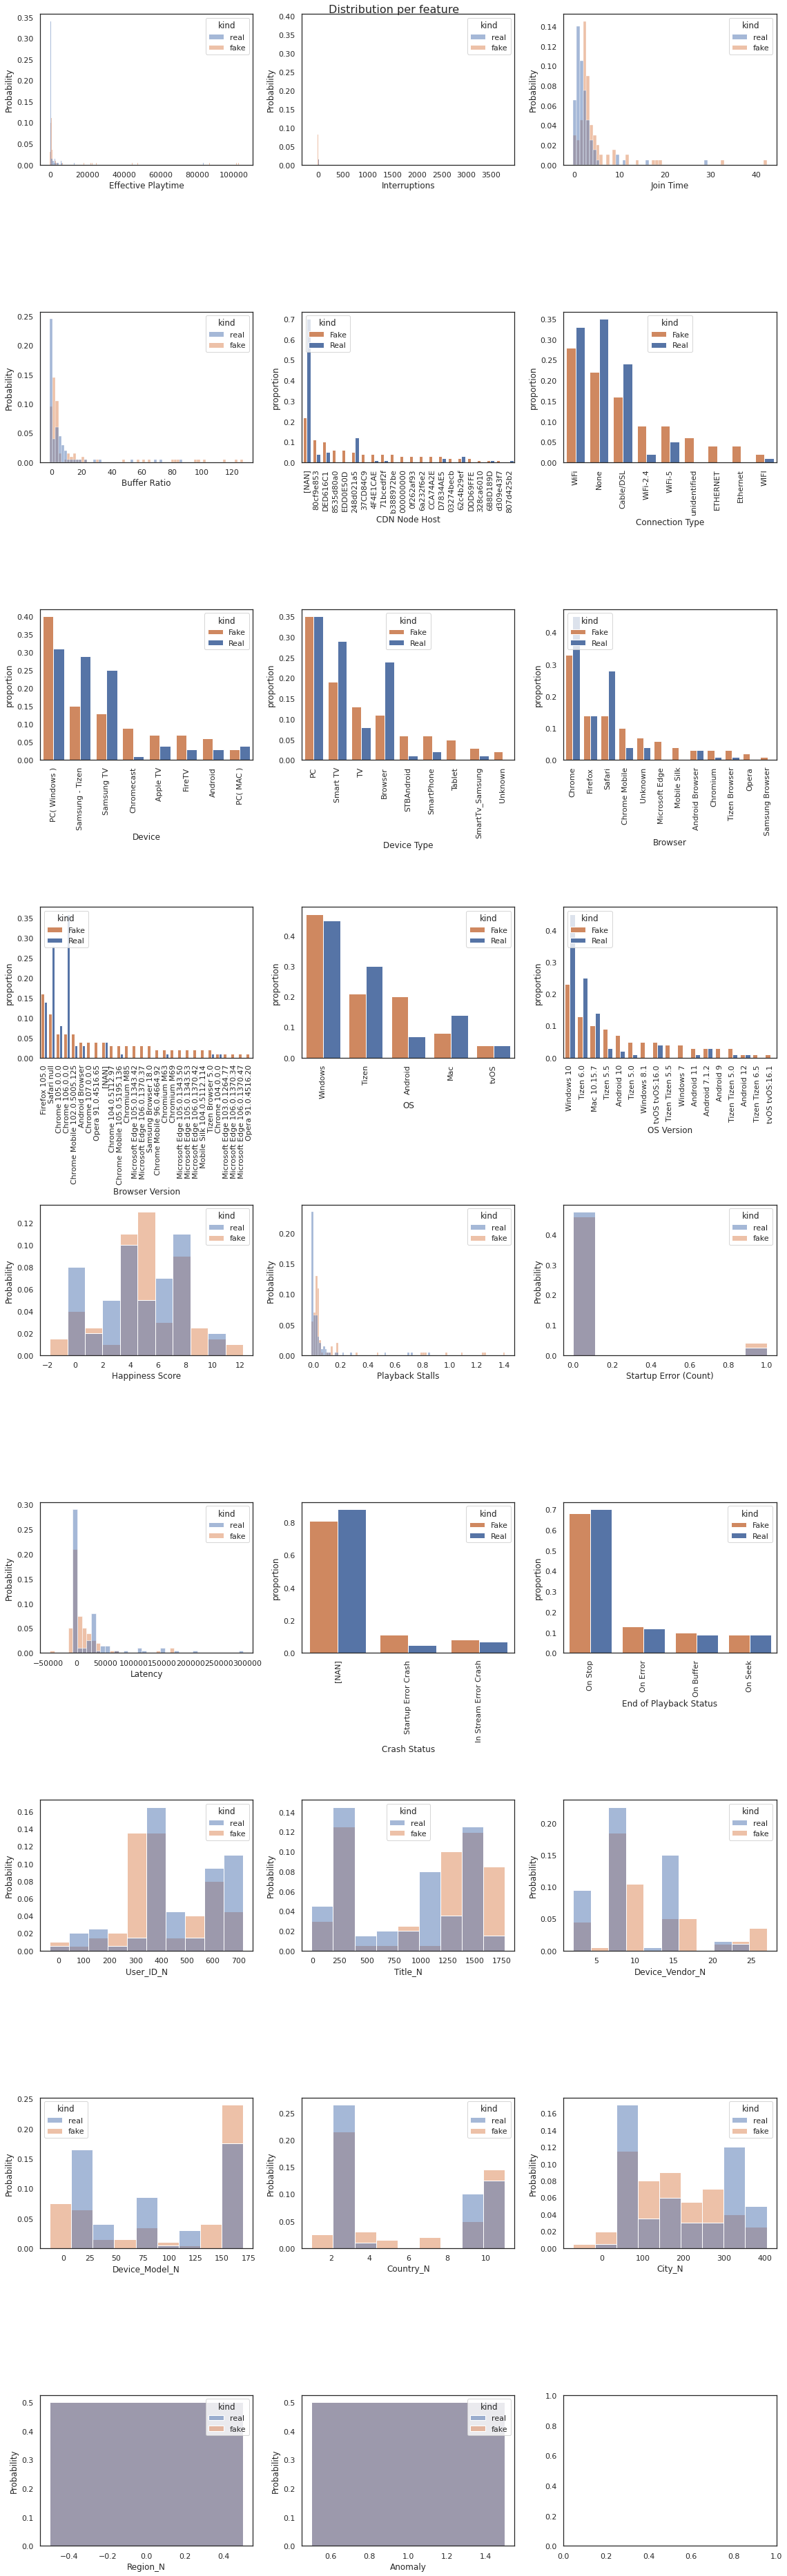

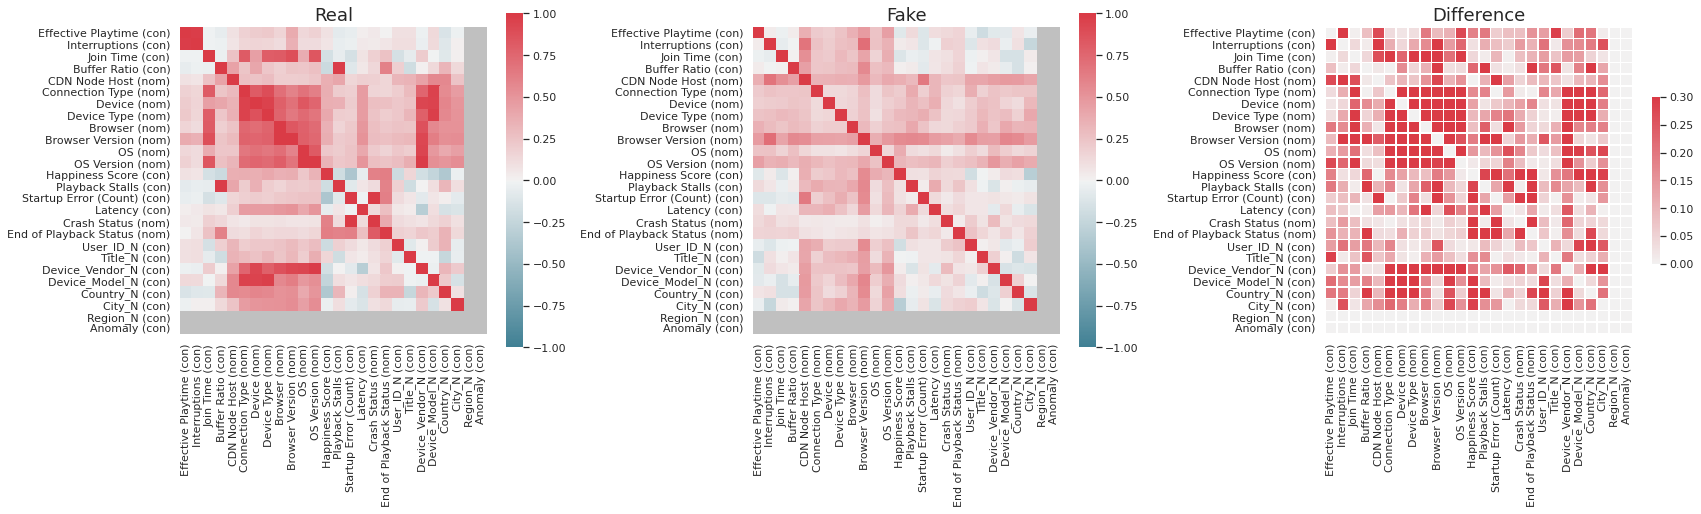

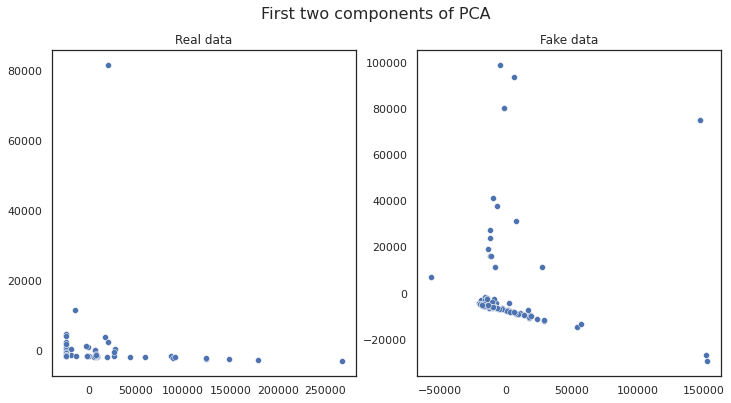

In [ ]:
table_evaluator_anom = TableEvaluator(original_set_with_anom, synthetic_data_with_anom)
table_evaluator_anom.visual_evaluation()

## in the specific feature (anomalous)

In [ ]:
table_evaluator_anom.evaluate(target_col='Effective Playtime')

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/table_evaluator/metrics.py:42: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.0000   0.0000              0.0000
DecisionTreeClassifier_real   0.0500   0.0000              0.0000
LogisticRegression_fake       0.0000   0.0000              0.0000
LogisticRegression_real       0.0000   0.0000              0.0000
MLPClassifier_fake            0.0000   0.0000              0.0000
MLPClassifier_real            0.0500   0.0000              0.0000
RandomForestClassifier_fake   0.0000   0.0000              0.0000
RandomForestClassifier_real   0.0500   0.0000              0.0000

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    4.1469
nearest neighbor std                     1.1101

Miscellaneous results:
                                  Result
Column Cor

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Validation through anomaly detection 

# Encoding with get_dummies

In [ ]:
synthetic_data_cpy = synthetic_data.copy() 

In [ ]:
# to be encoded
df_categorical_fields_encod = ['Connection Type', 'Device', 'Device Type', 'Browser', "Browser Version", 'OS', "OS Version", 'Crash Status', 'End of Playback Status', 'Country_N', 'Region_N', 'CDN Node Host']

In [ ]:
synthetic_data_cpy.shape

(10000, 26)

In [ ]:
encoded_features = pd.get_dummies(data=synthetic_data_cpy, columns= df_categorical_fields_encod)

In [ ]:
# drop the features that was encoeded from get_dummies
synthetic_data_cpy.drop(df_categorical_fields_encod, axis=1 ,inplace=True)

In [ ]:
df_synthetic_data = pd.concat([encoded_features,synthetic_data_cpy], axis='columns')

In [ ]:
df_synthetic_data.shape

(10000, 505)

### min-max scaler for the model

In [ ]:
# MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_synthetic_data)
df_synthetic_data = pd.DataFrame(df_scaled, columns=df_synthetic_data.columns)

In [ ]:
df_synthetic_data.drop(['Anomaly'], axis=1, inplace=True)

### Generating of the Isolation Forest model and setting the parameters

In [ ]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=0.01)

### Model fitting with the dataset we have for detecting anomaly

In [ ]:
model.fit(df_synthetic_data)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_features=3, n_estimators=200, n_jobs=-1,
                random_state=42)

### Adding the anomaly score after applying Isolation Forest to the data we have 

In [ ]:
df_synthetic_data['Anomaly_pred'] = pd.Series(model.predict(df_synthetic_data))

In [ ]:
df_synthetic_data.shape

(10000, 504)

In [ ]:
# Labelling anomalous requests detected by Isolation Forest 
df_synthetic_data['Anomaly_pred'] = df_synthetic_data['Anomaly_pred'].map( {1: 0, -1: 1} )

In [ ]:
df_synthetic_data['Anomaly_pred'].value_counts()

0    9900
1     100
Name: Anomaly_pred, dtype: int64

In [ ]:
df_synthetic_data

,Effective Playtime,Interruptions,Join Time,Buffer Ratio,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,...,Happiness Score,Playback Stalls,Startup Error (Count),Latency,User_ID_N,Title_N,Device_Vendor_N,Device_Model_N,City_N,Anomaly_pred
0,0.0089,0.6604,0.0284,0.0105,0.1351,0.0238,0.0000,0.2222,0.5653,0.2148,...,0.1351,0.0238,0.0000,0.2222,0.5653,0.2148,0.2188,0.1093,0.2676,0
1,0.0086,0.6604,0.0243,0.0107,0.1333,0.0210,0.0000,0.2229,0.4008,0.6562,...,0.1333,0.0210,0.0000,0.2229,0.4008,0.6562,0.2188,0.7760,0.8370,0
2,0.0087,0.6604,0.0538,0.0106,0.1344,0.0218,0.0000,0.2236,0.8825,0.6668,...,0.1344,0.0218,0.0000,0.2236,0.8825,0.6668,0.2188,0.5683,0.9034,0
3,0.0089,0.6604,0.0248,0.0107,0.8280,0.0232,0.0000,0.2234,0.5522,0.9202,...,0.8280,0.0232,0.0000,0.2234,0.5522,0.9202,0.2188,0.9399,0.2233,0
4,0.0087,0.6604,0.0951,0.0107,0.1344,0.0239,0.0000,0.2237,0.8734,0.6859,...,0.1344,0.0239,0.0000,0.2237,0.8734,0.6859,0.2188,0.9508,0.9014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.4269,0.6321,0.1482,0.3772,0.4843,0.0362,0.0000,0.2142,0.0078,0.3850,...,0.4843,0.0362,0.0000,0.2142,0.0078,0.3850,0.6562,0.0437,0.2636,1
9996,0.0105,0.6274,1.0000,0.0466,0.6468,0.0323,0.0000,0.1797,0.5235,0.6494,...,0.6468,0.0323,0.0000,0.1797,0.5235,0.6494,0.6562,0.0437,0.2274,1
9997,0.0127,0.6132,0.0851,0.0184,0.4261,0.0390,0.0000,0.1822,0.5783,0.9482,...,0.4261,0.0390,0.0000,0.1822,0.5783,0.9482,0.4375,0.9071,0.8350,1
9998,0.2449,0.6557,0.1254,0.0185,0.6328,0.0395,0.0000,0.1931,0.5444,0.3166,...,0.6328,0.0395,0.0000,0.1931,0.5444,0.3166,0.6250,0.0492,0.2636,1


In [ ]:
df_synthetic_data['Anomaly'] = synthetic_data['Anomaly']

In [ ]:
df_confusion = pd.crosstab(df_synthetic_data['Anomaly'], df_synthetic_data['Anomaly_pred'] )

### Building confusion matrix

In [ ]:
df_confusion

Anomaly_pred,0,1
Anomaly,,
0,9884,16
1,16,84


[[9884   16]
 [  16   84]]


Text(0.5, 1.0, 'Synthetic data anomaly detection confusion matrix')

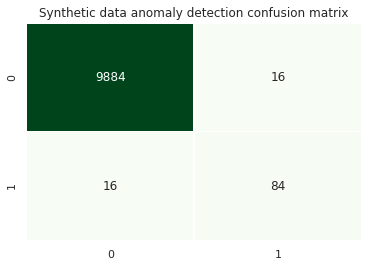

In [ ]:
conf_m = metrics.confusion_matrix(df_synthetic_data['Anomaly'], df_synthetic_data['Anomaly_pred'])
print(conf_m)
sns.heatmap(conf_m, annot = True,  linewidths=.5, cbar =None, fmt='g', cmap='Greens')
plt.title('Synthetic data anomaly detection confusion matrix')

### Calculating precision and recall

In [ ]:
precision = precision_score(df_synthetic_data['Anomaly'], df_synthetic_data['Anomaly_pred'])
recall = recall_score(df_synthetic_data['Anomaly'], df_synthetic_data['Anomaly_pred'])

In [ ]:
precision

0.84

In [ ]:
recall

0.84

In [ ]:
df_synthetic_data.to_csv('df_synthetic_data.csv')